# MNIST Variational Autoencoder

This Variational Autoencoder (VAE) uses an encoder to transform the 784-dimensional MNIST input down to a latent dimension. It then transforms that into a latent representation $(\mu, \sigma^2)$. It reparametrizes this mean and variance into  $ z = \mu + \epsilon\sigma^2$, where $\epsilon \sim \mathcal{N}(0, 1)$. The decoder then turns $z$ back into an image.

The model loss function consists of a reproduction loss and a KL divergence between the latent distribution and a standard gaussian ($\mathcal{N}(0, 1)$). This enforces an accurate reconstruction while regularizing the latent distribution. This then allows for the decoder to sample from the latent distribution to generate images.



## Imports

In [3]:
import torch.optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from model import VAE
import matplotlib.pyplot as plt

# Get MNIST Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

data = torchvision.datasets.MNIST(
    root="mnist",
    train = True,
    download=True,
    transform=transform
)

## Hyperparameters and initialize models

In [5]:
device = "mps"
lr = 1e-3
batch_size = 512

model = VAE(
    input_dim=28*28,
    hidden_dim=256,
    latent_dim=64,
    device=device
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction="sum")

loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=2)

## Define Loss Function

In [6]:
def vae_loss(input, output, mean, log_variance):
    reproduction_loss = criterion(output, input)
    kl_loss =-0.5 * torch.sum(1+ log_variance - mean.pow(2) - log_variance.exp())

    return reproduction_loss,  kl_loss

## Train Model

In [7]:
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for image, _ in loader:
        image = image.reshape(-1, 784).to(device)

        output, mean, variance = model(image)
        recon_loss, kl_loss = vae_loss(image, output, mean, variance)
        loss = recon_loss + kl_loss
        total_loss += loss.item()

        model.zero_grad()
        loss.backward()
        optimizer.step()
    print(
        f"Epoch {epoch + 1}/{epochs} | Average Batch Loss: {total_loss/(len(loader) * image.shape[0])} | KL {kl_loss} | Recon {recon_loss}"
    )

Epoch 1/100 | Average Batch Loss: 1269.1104720810713 | KL 199.658935546875 | Recon 17639.33984375
Epoch 2/100 | Average Batch Loss: 947.2690334858868 | KL 194.40853881835938 | Recon 16784.890625
Epoch 3/100 | Average Batch Loss: 894.7057457185734 | KL 244.68408203125 | Recon 15406.42578125
Epoch 4/100 | Average Batch Loss: 870.7007410081767 | KL 265.72906494140625 | Recon 14696.3037109375
Epoch 5/100 | Average Batch Loss: 857.6242086119571 | KL 242.30677795410156 | Recon 14840.767578125
Epoch 6/100 | Average Batch Loss: 847.0490720932094 | KL 287.02392578125 | Recon 15058.951171875
Epoch 7/100 | Average Batch Loss: 836.4909245550296 | KL 305.03509521484375 | Recon 13515.017578125
Epoch 8/100 | Average Batch Loss: 827.444571629756 | KL 286.470947265625 | Recon 14039.51171875
Epoch 9/100 | Average Batch Loss: 820.2962097340385 | KL 272.01812744140625 | Recon 15620.6484375
Epoch 10/100 | Average Batch Loss: 814.256011704267 | KL 314.921142578125 | Recon 13786.078125
Epoch 11/100 | Average

## Visualize Latent Space


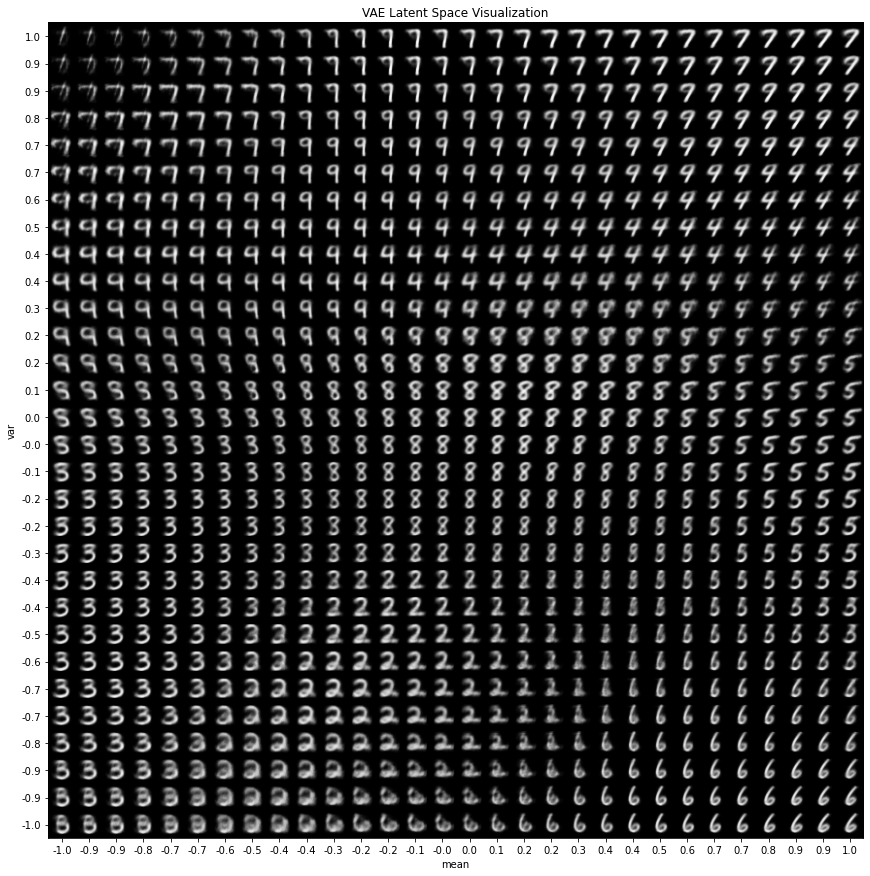

In [20]:
import numpy as np
digit_size = 28
n = 30
scale = 1
figsize = 15

figure = np.zeros((digit_size * n, digit_size * n))

# construct a grid
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
        x_decoded = model.decode(z_sample)
        digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit
plt.figure(figsize=(figsize, figsize))
plt.title('VAE Latent Space Visualization')
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("mean")
plt.ylabel("var")
plt.imshow(figure, cmap="gray")
plt.show()